In [1]:
import pandas as pd
import pandas_profiling

In [2]:
df = pd.read_csv('../data/census.csv')

In [3]:
profile = pandas_profiling.ProfileReport(df)

In [4]:
profile

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


In [10]:
import itertools
import os
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, FunctionTransformer, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

In [4]:
df.columns = [col.strip() for col in df.columns]
df = df.drop_duplicates()
df['salary'] = df['salary'].apply(lambda x: x==' >50K')

In [5]:
df.sex.value_counts(dropna=False)

 Male      21775
 Female    10762
Name: sex, dtype: int64

In [6]:
X = df.copy()
y = X.pop("salary")

In [7]:
X.columns

Index(['age', 'workclass', 'fnlgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=df['education'],
    random_state=42,
)

In [13]:
#df['education-num'].value_counts()

In [14]:
ordinal_categorical = ["workclass","education","native-country"]
non_ordinal_categorical = ["education-num","marital-status",'occupation', 'relationship', 'race', 'sex']
ordinal_categorical_preproc = OrdinalEncoder()
non_ordinal_categorical_preproc = make_pipeline(
   SimpleImputer(strategy="most_frequent"),
   OneHotEncoder()
)
numeric_features = ['age','fnlgt','capital-gain', 'capital-loss', 'hours-per-week']
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler()
)

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ordinal_cat", ordinal_categorical_preproc, ordinal_categorical),
        ("non_ordinal_cat", non_ordinal_categorical_preproc, non_ordinal_categorical),
    ],
    remainder="drop",  # This drops the columns that we do not transform
)

In [16]:
used_columns = list(itertools.chain.from_iterable([x[2] for x in preprocessor.transformers]))
used_columns

['age',
 'fnlgt',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass',
 'education',
 'native-country',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex']

In [17]:
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier()),
    ]
)

In [18]:
pipe.fit(X_train[used_columns], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlgt',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('ordinal_cat',
                                                  OrdinalEncoder(),
                                                  ['workclass', 'education',
                                                   'native-country'])

In [19]:
pred = pipe.predict(X_val[used_columns])
pred_proba = pipe.predict_proba(X_val[used_columns])

In [29]:
y_val.shape,pred.shape

((8135,), (8135,))

In [32]:
score = roc_auc_score(y_val, pred, average="macro")

In [36]:
feat_names = np.array(
        pipe["preprocessor"].transformers[0][-1]
        + pipe["preprocessor"].transformers[1][-1]
        + pipe["preprocessor"].transformers[2][-1]
    )

In [40]:
def plot_feature_importance(pipe):

    # We collect the feature importance for all non-nlp features first
    feat_names = np.array(
        pipe["preprocessor"].transformers[0][-1]
        + pipe["preprocessor"].transformers[1][-1]
        + pipe["preprocessor"].transformers[2][-1]
    )
    feat_imp = pipe["classifier"].feature_importances_[: len(feat_names)]
    fig_feat_imp, sub_feat_imp = plt.subplots(figsize=(10, 10))
    idx = np.argsort(feat_imp)[::-1]
    sub_feat_imp.bar(range(feat_imp.shape[0]), feat_imp[idx], color="r", align="center")
    _ = sub_feat_imp.set_xticks(range(feat_imp.shape[0]))
    _ = sub_feat_imp.set_xticklabels(feat_names[idx], rotation=90)
    fig_feat_imp.tight_layout()
    return fig_feat_imp

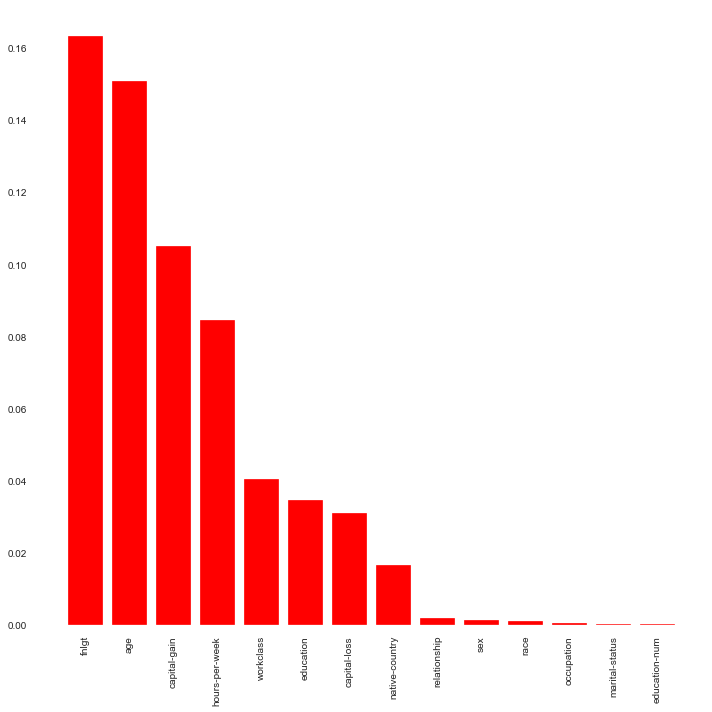

In [41]:
fig_feat_imp = plot_feature_importance(pipe)

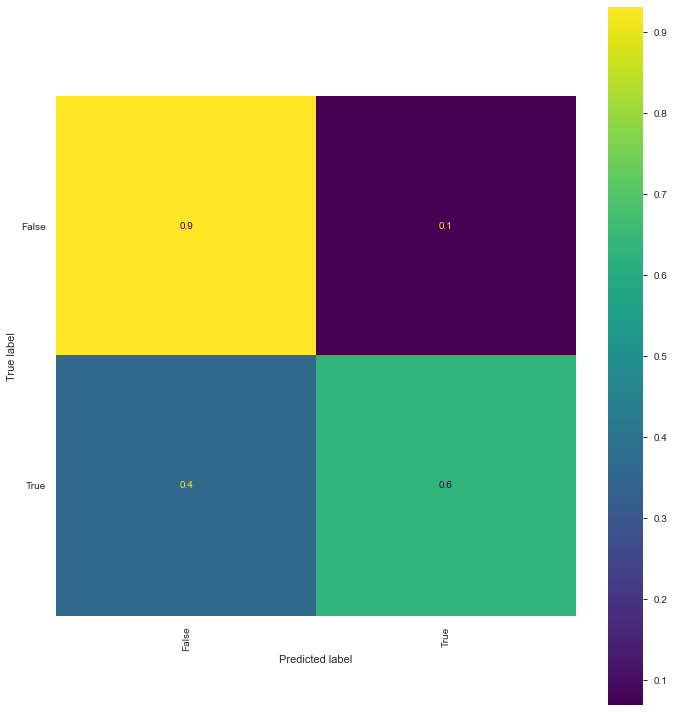

In [42]:

    fig_cm, sub_cm = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(
        pipe,
        X_val[used_columns],
        y_val,
        ax=sub_cm,
        normalize="true",
        values_format=".1f",
        xticks_rotation=90,
    )
    fig_cm.tight_layout()


